In [69]:
%pylab inline
%matplotlib inline
import os
import sys
import copy
import pickle
import numpy
import time
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.pyplot import figure, subplots, imshow, xticks, yticks, title
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import KMeans
from statistics import mean
from scipy.stats import entropy
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from statistics import mean
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import time
import copy
import scipy.stats
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr
from sklearn.metrics import mutual_info_score
import matplotlib.colors as mcolors
from scipy.stats import ks_2samp
import ast  
import re


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['copy', 'mean']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Models


## Attention Layer


In [71]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim**0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted

## RNN


In [72]:
class NetRNN(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer to match CustomRNN
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True)
        
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        x = self.expand_layer(x)
        x = torch.tanh(x)

        self.h0 = torch.Tensor(numpy.zeros((1, x.shape[0], self.hidden_dim)))
        out, self.h0 = self.rnnLayer(x, self.h0)
        out = torch.tanh(out)
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.Tensor(numpy.zeros((1, 1, self.hidden_dim)))
            for i in range(x.shape[1]):
                # Apply the expansion layer to each step
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.tanh(step_input)

                out, h0 = self.rnnLayer(step_input, h0)
                H.append(out.detach().numpy().flatten())
            out = torch.tanh(out)
            out = torch.tanh(self.outputLayer(out[:, -1, :]))
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)


## RNNA


In [77]:
class NetRNNWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNNWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Attention layer
        self.attention = SelfAttention(inp)  # Assuming SelfAttention is defined elsewhere

        # Expansion layer to match CustomRNN
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True, nonlinearity='tanh')
        
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply attention
        attn_out = self.attention(x)
        # Apply the expansion layer with tanh activation
        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.tanh(expanded_attn_out)

        # RNN processing
        h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        rnn_out, _ = self.rnnLayer(expanded_attn_out, h0)
        rnn_out = torch.tanh(rnn_out)

        # Final output layer
        out = torch.tanh(self.outputLayer(rnn_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Apply the expansion layer with tanh activation
                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.tanh(expanded_attn_out)

                # RNN processing
                out, h0 = self.rnnLayer(expanded_attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)


## LSTM


In [ ]:
class NetLSTM(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # LSTM layer
        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim/2), 1, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(int(self.hidden_dim/2), 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        x = self.expand_layer(x)
        x = torch.tanh(x)

        # Initialize hidden and cell states
        self.h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim/2)),
                   torch.zeros(1, x.shape[0], int(self.hidden_dim/2)))

        # LSTM processing
        out, self.h0 = self.lstmLayer(x, self.h0)
        out = torch.tanh(out)  # Apply tanh to the LSTM output if needed

        # Concatenate hidden and cell states
        hh = numpy.concatenate((self.h0[0].detach().numpy(), self.h0[1].detach().numpy()), 2)
        self.hidden.append(hh)

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim/2)),
                  torch.zeros(1, 1, int(self.hidden_dim/2)))
            for i in range(x.shape[1]):
                # Apply the expansion layer to each step
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.tanh(step_input)

                out, h0 = self.lstmLayer(step_input, h0)
                hh = numpy.concatenate((h0[0].detach().numpy().flatten(), h0[1].detach().numpy().flatten()))
                H.append(hh.flatten())

            out = torch.tanh(out)  # Apply tanh to the LSTM output if needed
            out = torch.tanh(self.outputLayer(out[:, -1, :]))
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)
    
model = NetLSTM(hidden_dim=12)


## LSTMA


In [ ]:
class NetLSTMWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetLSTMWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Attention layer
        self.attention = SelfAttention(inp)  # Assuming SelfAttention is defined elsewhere

        # Expansion layer to match CustomRNN
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # LSTM layer
        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim/2), batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(int(self.hidden_dim/2), 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply attention
        attn_out = self.attention(x)

        # Apply the expansion layer with tanh activation
        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.tanh(expanded_attn_out)

        # LSTM processing
        h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim/2)),
              torch.zeros(1, x.shape[0], int(self.hidden_dim/2)))
        lstm_out, _ = self.lstmLayer(expanded_attn_out, h0)
        lstm_out = torch.tanh(lstm_out)

        # Final output layer
        out = torch.tanh(self.outputLayer(lstm_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim/2)),
                  torch.zeros(1, 1, int(self.hidden_dim/2)))
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Apply the expansion layer with tanh activation
                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.tanh(expanded_attn_out)

                # LSTM processing
                out, h0 = self.lstmLayer(expanded_attn_out, h0)
                H.append(torch.cat((h0[0].detach(), h0[1].detach()), 2).numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)
    
model = NetLSTMWithAttention(hidden_dim=12)


## GRU


In [ ]:
class NetGRU(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # GRU layer
        self.gruLayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        x = self.expand_layer(x)
        x = torch.tanh(x)

        # GRU processing
        self.h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        out, self.h0 = self.gruLayer(x, self.h0)
        out = torch.tanh(out)

        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Apply the expansion layer to each step
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.tanh(step_input)

                # GRU processing
                out, h0 = self.gruLayer(step_input, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)  # Apply tanh to the GRU output if needed
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)
    
model = NetGRU(hidden_dim=12)


## GRUA


In [ ]:
class NetGRUMWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetGRUMWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Attention layer
        self.attention = SelfAttention(inp)  # Assuming SelfAttention is defined elsewhere

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # GRU layer
        self.gruLayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply attention
        attn_out = self.attention(x)

        # Apply the expansion layer with tanh activation
        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.tanh(expanded_attn_out)

        # GRU processing
        self.h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        out, self.h0 = self.gruLayer(expanded_attn_out, self.h0)
        out = torch.tanh(out)

        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Apply the expansion layer with tanh activation
                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.tanh(expanded_attn_out)

                # GRU processing
                out, h0 = self.gruLayer(expanded_attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)  # Apply tanh to the GRU output if needed
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)

model = NetGRUMWithAttention(hidden_dim=12)


# Data Generation


## Data Generation Top


In [74]:
def generateTrainDataNoiseTop(num_samples, min_max, noise = 3):
    s = []  # Sequences
    t = []  # Labels
    params = {
        "min_length": min_max[0],
        "max_length": min_max[1],
        "fill": 0,
        "value_1": -1,
        "value_2": 1,
        "noise_level": noise,  # Maximum number of additional non-zero values to add as noise
    }
    
    for _ in range(num_samples):
        common_length = np.random.randint(params["min_length"], params["max_length"] + 1)

        array_A = np.full(common_length, params["fill"])
        array_B = np.full(common_length, params["fill"])
        array_C = np.full(common_length, params["fill"])

        # Set specific values for the first index of array A and the second index of array B
        value_A = np.random.choice([params["value_1"], params["value_2"]])
        array_A[0] = value_A
        value_B = np.random.choice([params["value_1"], params["value_2"]])
        array_B[1] = value_B

        # Exclude the first two indices and the last two indices for noise addition
        possible_indices = np.arange(2, common_length - 2)

        # Add noise in array A and B, excluding the first two indices
        for array in [array_A, array_B]:
            noise_indices = np.random.choice(possible_indices, size=np.random.randint(1, params["noise_level"] + 1), replace=False)
            for index in noise_indices:
                array[index] = np.random.choice([params["value_1"], params["value_2"]])

        # Set the last two values in array C for XOR/XNOR operation
        value_C = np.random.choice([params["value_1"], params["value_2"]])
        array_C[-1] = value_C
        array_C[-2] = value_C

        # Logic for determining the result based on XOR/XNOR operation
        mapped_value_A = 1 if value_A == params["value_2"] else 0
        mapped_value_B = 1 if value_B == params["value_2"] else 0
        if value_C == params["value_1"]:  # XOR
            result = int(mapped_value_A != mapped_value_B)
        else:  # XNOR
            result = int(mapped_value_A == mapped_value_B)

        # Mapping back to original values for the label
        label_value_A = params["value_2"] if mapped_value_A == 1 else params["value_1"]
        label_value_B = params["value_2"] if mapped_value_B == 1 else params["value_1"]
        results_XORNOR = params["value_2"] if result == 1 else params["value_1"]

        # Constructing the label array
        label_arr = [label_value_A, label_value_B, results_XORNOR]

        combined_array = np.vstack([array_A, array_B, array_C]).T
        s.append(combined_array)
        t.append(label_arr)

    return s, np.array(t)


In [66]:
x= generateTrainDataNoiseTop(1, [10,10], 4)

In [67]:
x

([array([[-1,  0,  0],
         [ 0,  1,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 1, -1,  0],
         [ 0,  0,  0],
         [-1, -1,  0],
         [-1,  0,  0],
         [ 0,  0, -1],
         [ 0,  0, -1]])],
 array([[-1,  1,  1]]))

## Data Generation Bottom


In [48]:
def generateTrainDataNoiseBottom(num_samples, min_max, noise=3):
    s = []  # Sequences
    t = []  # Labels
    params = {
        "min_length": min_max[0],
        "max_length": min_max[1],
        "fill": 0,
        "value_1": -1,
        "value_2": 1,
        "noise_level": noise,  # Maximum number of additional non-zero values to add as noise
    }
    
    for _ in range(num_samples):
        common_length = np.random.randint(params["min_length"], params["max_length"] + 1)

        array_A = np.full(common_length, params["fill"])
        array_B = np.full(common_length, params["fill"])
        array_C = np.full(common_length, params["fill"])

        # Exclude the first two indices, the last four indices for noise addition
        possible_indices = np.arange(0, common_length - 4)

        # Add noise in array A and B, excluding specific indices
        for array in [array_A, array_B]:
            noise_indices = np.random.choice(possible_indices, size=np.random.randint(1, params["noise_level"] + 1), replace=False)
            for index in noise_indices:
                array[index] = np.random.choice([params["value_1"], params["value_2"]])

        # Set specific values for the 4th and 3rd positions from the bottom of array A and B
        value_A = np.random.choice([params["value_1"], params["value_2"]])
        array_A[-4] = value_A
        value_B = np.random.choice([params["value_1"], params["value_2"]])
        array_B[-3] = value_B

        # Set the last two values in array C for XOR/XNOR operation
        value_C = np.random.choice([params["value_1"], params["value_2"]])
        array_C[-1] = value_C
        array_C[-2] = value_C

        # Logic for determining the result based on XOR/XNOR operation
        mapped_value_A = 1 if value_A == params["value_2"] else 0
        mapped_value_B = 1 if value_B == params["value_2"] else 0
        if value_C == params["value_1"]:  # XOR
            result = int(mapped_value_A != mapped_value_B)
        else:  # XNOR
            result = int(mapped_value_A == mapped_value_B)

        # Mapping back to original values for the label
        label_value_A = params["value_2"] if mapped_value_A == 1 else params["value_1"]
        label_value_B = params["value_2"] if mapped_value_B == 1 else params["value_1"]
        results_XORNOR = params["value_2"] if result == 1 else params["value_1"]

        # Constructing the label array
        label_arr = [label_value_A, label_value_B, results_XORNOR]

        combined_array = np.vstack([array_A, array_B, array_C]).T
        s.append(combined_array)
        t.append(label_arr)

    return s, np.array(t)


In [64]:
x = generateTrainDataNoiseBottom(1,[10,10], 5)

In [65]:
x

([array([[ 0, -1,  0],
         [ 1,  1,  0],
         [ 0,  0,  0],
         [ 0,  1,  0],
         [-1,  1,  0],
         [-1,  0,  0],
         [ 1,  0,  0],
         [ 0,  1,  0],
         [ 0,  0, -1],
         [ 0,  0, -1]])],
 array([[ 1,  1, -1]]))

# Train Models


In [79]:
collectorA = dict()
#min_lengths = [5, 10, 10, 20, 20, 40, 40, 70,100]
#max_lengths = [5, 10, 15, 20, 25, 40, 45,75,140]
num_samples = 100
min_lengths = [10]
max_lengths = [10]
focus = 'Top'
for rep in range(3):  # Number of repetitions
    for min_len, max_len in zip(min_lengths, max_lengths):
        # Select the model based on 'kind'
        #for kind in ["RNN", "RNNA","LSTM", "LSTMA", "GRU", "GRUA"]:
        for kind in ["RNNA"]:
        # Select the model based on 'kind'
            if kind == "RNN":
                model = NetRNN(hidden_dim=12, inp=3)
            elif kind == "RNNA":
                model = NetRNNWithAttention(hidden_dim=12, inp=3)
            elif kind == "RNNE":
                model = NetRNNWithAttentionExpFirst(hidden_dim=12, inp=3)
            elif kind == "LSTM":
                model = NetLSTM(hidden_dim=12, inp=3)
            elif kind == "LSTMA":
                model = NetLSTMWithAttention(hidden_dim=12, inp=3)
            elif kind == "LSTME":
                model = NetLSTMWithAttentionExpFirst(hidden_dim=12, inp=3)
            elif kind == "GRU":
                model = NetGRU(hidden_dim=12, inp=3)
            elif kind == "GRUA":
                model = NetGRUMWithAttention(hidden_dim=12, inp=3)
            elif kind == "GRUE":
                model = NetGRUMWithAttentionExpFirst(hidden_dim=12, inp=3)

            optimizer = optim.Adam(model.parameters())
            criterion = nn.MSELoss()
            acc = 0.0
            W = []
            AC = []
            start_time = time.time()  # Start time of the epoch

            while True:
                sequences, targets = generateTrainDataNoiseTop(num_samples, [min_len,max_len],4)
                total_loss = 0
                total_acc = 0
                count = 0

                for seq, target in zip(sequences, targets):
                    optimizer.zero_grad()
                    seq_tensor = torch.Tensor([seq])  # Add an extra dimension for batch
                    target_tensor = torch.Tensor([target])

                    output = model(seq_tensor)
                    loss = criterion(output, target_tensor)
                    total_loss += loss.item()

                    loss.backward()
                    optimizer.step()

                    # Calculate accuracy
                    A = 1.0 * (target_tensor.detach() > 0.0)
                    B = 1.0 * (output.detach() > 0.0)
                    acc = (1.0 * (A.flatten() == B.flatten())).mean()
                    total_acc += acc
                    count += 1

                avg_loss = total_loss / count
                avg_acc = total_acc / count
                W.append(avg_loss)
                AC.append(avg_acc)
                print(f"{kind}, rep: {rep}, epoch: {len(AC)}, acc: {avg_acc}, Loss {avg_loss}")

                # Check for stopping condition
                if avg_acc >= 0.97 or len(W)>2000:
                    break

            end_time = time.time()  # End time of the epoch
            epoch_duration = end_time - start_time  # Calculate duration
            collectorA[f"{kind}_rep_{rep}_min_{min_len} max_{max_len}"] = AC
            torch.save(model, f'./ModelsWithNoise/model_{kind}_{focus}_min_{min_len}_max_{max_len}_rep_{rep}.model')
            print(f"{kind:<20} Rep: {rep:<3} Epoch: {len(A):<5} Acc: {avg_acc:.4f} " f"_min_{min_len}_max_{max_len} Time: {epoch_duration:.2f} sec")
            df=pd.DataFrame()
            df["accuracy"]=AC
            df["loss"]=W
            df.to_csv(f'./ModelsWithNoise/score_{kind}_{focus}_min_{min_len}_max_{max_len}_rep_{rep}.csv')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 3])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RNNA, rep: 0, epoch: 1, acc: 0.4599999189376831, Loss 1.0309597945213318
RNNA, rep: 0, epoch: 2, acc: 0.5633332133293152, Loss 0.9830452024936676
RNNA, rep: 0, epoch: 3, acc: 0.6266667246818542, Loss 0.9493826657533646
RNNA, rep: 0, epoch: 4, acc: 0.6166667342185974, Loss 0.92719462454319
RNNA, rep: 0, epoch: 5, acc: 0.6366666555404663, Loss 0.8863909927010536
RNNA, rep: 0, epoch: 6, acc: 0.5833332538604736, Loss 0.9169154167175293
RNNA, rep: 0, epoch: 7, acc: 0.6400001645088196, Loss 0.8587310463190079
RNNA, rep: 0, epoch: 8, acc: 0.6666666269302368, Loss 0.8065886563062667
RNNA, rep: 0, epoch: 9, acc: 0.6899999380111694, Loss 0.7702305319905282
RNNA, rep: 0, epoch: 10, acc: 0.6833335757255554, Loss 0.8083662647008896
RNNA, rep: 0, epoch: 11, acc: 0.653333306312561, Loss 0.8499583619832992
RNNA, rep: 0, epoch: 12, acc: 0.6300001740455627, Loss 0.8468417842686177
RNNA, rep: 0, epoch: 13, acc: 0.6666668057441711, Loss 0.7704320168495178
RNNA, rep: 0, epoch: 14, acc: 0.6633334159851074, 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 3])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RNNA, rep: 1, epoch: 2, acc: 0.48666658997535706, Loss 1.0182681447267532
RNNA, rep: 1, epoch: 3, acc: 0.5199999809265137, Loss 0.9954245841503143
RNNA, rep: 1, epoch: 4, acc: 0.550000011920929, Loss 0.9814268797636032
RNNA, rep: 1, epoch: 5, acc: 0.6233334541320801, Loss 0.9420144674181938
RNNA, rep: 1, epoch: 6, acc: 0.5899999737739563, Loss 0.9542097580432892
RNNA, rep: 1, epoch: 7, acc: 0.6066667437553406, Loss 0.9273202285170555
RNNA, rep: 1, epoch: 8, acc: 0.5999999642372131, Loss 0.9316691073775292
RNNA, rep: 1, epoch: 9, acc: 0.6266667246818542, Loss 0.9068052226305008
RNNA, rep: 1, epoch: 10, acc: 0.5833333730697632, Loss 0.950849384367466
RNNA, rep: 1, epoch: 11, acc: 0.6366667151451111, Loss 0.904047605395317
RNNA, rep: 1, epoch: 12, acc: 0.6500001549720764, Loss 0.8642413204908371
RNNA, rep: 1, epoch: 13, acc: 0.6700001358985901, Loss 0.8268149903416634
RNNA, rep: 1, epoch: 14, acc: 0.6000001430511475, Loss 0.9149311116337776
RNNA, rep: 1, epoch: 15, acc: 0.6433334350585938

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 3])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RNNA, rep: 2, epoch: 2, acc: 0.5, Loss 1.00424389064312
RNNA, rep: 2, epoch: 3, acc: 0.580000102519989, Loss 0.9600734740495682
RNNA, rep: 2, epoch: 4, acc: 0.5699999928474426, Loss 0.9433654546737671
RNNA, rep: 2, epoch: 5, acc: 0.6333333253860474, Loss 0.8875685355067253
RNNA, rep: 2, epoch: 6, acc: 0.5533333420753479, Loss 0.9842047098279
RNNA, rep: 2, epoch: 7, acc: 0.5866667032241821, Loss 0.9112843337655068
RNNA, rep: 2, epoch: 8, acc: 0.5966667532920837, Loss 0.9460870769619941
RNNA, rep: 2, epoch: 9, acc: 0.5700000524520874, Loss 0.9151977211236954
RNNA, rep: 2, epoch: 10, acc: 0.5633333325386047, Loss 0.9524433535337448
RNNA, rep: 2, epoch: 11, acc: 0.6066666841506958, Loss 0.9188391023874283
RNNA, rep: 2, epoch: 12, acc: 0.663333535194397, Loss 0.8567772954702377
RNNA, rep: 2, epoch: 13, acc: 0.6733333468437195, Loss 0.8493795397877694
RNNA, rep: 2, epoch: 14, acc: 0.5966668128967285, Loss 0.8560215061903
RNNA, rep: 2, epoch: 15, acc: 0.6733333468437195, Loss 0.85867725819349

In [96]:
collectorA = dict()
#min_lengths = [5, 10, 10, 20, 20, 40, 40, 70,100]
#max_lengths = [5, 10, 15, 20, 25, 40, 45,75,140]
num_samples = 100
min_lengths = [10]
max_lengths = [10]
focus = 'Bottom'
for rep in range(3):  # Number of repetitions
    for min_len, max_len in zip(min_lengths, max_lengths):
        # Select the model based on 'kind'
        #for kind in ["RNN", "RNNA","LSTM", "LSTMA", "GRU", "GRUA"]:
        for kind in ["RNNA"]:
        # Select the model based on 'kind'
            if kind == "RNN":
                model = NetRNN(hidden_dim=12, inp=3)
            elif kind == "RNNA":
                model = NetRNNWithAttention(hidden_dim=12, inp=3)
            elif kind == "RNNE":
                model = NetRNNWithAttentionExpFirst(hidden_dim=12, inp=3)
            elif kind == "LSTM":
                model = NetLSTM(hidden_dim=12, inp=3)
            elif kind == "LSTMA":
                model = NetLSTMWithAttention(hidden_dim=12, inp=3)
            elif kind == "LSTME":
                model = NetLSTMWithAttentionExpFirst(hidden_dim=12, inp=3)
            elif kind == "GRU":
                model = NetGRU(hidden_dim=12, inp=3)
            elif kind == "GRUA":
                model = NetGRUMWithAttention(hidden_dim=12, inp=3)
            elif kind == "GRUE":
                model = NetGRUMWithAttentionExpFirst(hidden_dim=12, inp=3)

            optimizer = optim.Adam(model.parameters())
            criterion = nn.MSELoss()
            acc = 0.0
            W = []
            AC = []
            start_time = time.time()  # Start time of the epoch

            while True:
                sequences, targets = generateTrainDataNoiseBottom(num_samples, [min_len,max_len],4)
                total_loss = 0
                total_acc = 0
                count = 0

                for seq, target in zip(sequences, targets):
                    optimizer.zero_grad()
                    seq_tensor = torch.Tensor([seq])  # Add an extra dimension for batch
                    target_tensor = torch.Tensor([target])

                    output = model(seq_tensor)
                    loss = criterion(output, target_tensor)
                    total_loss += loss.item()

                    loss.backward()
                    optimizer.step()

                    # Calculate accuracy
                    A = 1.0 * (target_tensor.detach() > 0.0)
                    B = 1.0 * (output.detach() > 0.0)
                    acc = (1.0 * (A.flatten() == B.flatten())).mean()
                    total_acc += acc
                    count += 1

                avg_loss = total_loss / count
                avg_acc = total_acc / count
                W.append(avg_loss)
                AC.append(avg_acc)
                print(f"{kind}, rep: {rep}, epoch: {len(AC)}, acc: {avg_acc}, Loss {avg_loss}")

                # Check for stopping condition
                if avg_acc >= 0.97 or len(W)>2000:
                    break

            end_time = time.time()  # End time of the epoch
            epoch_duration = end_time - start_time  # Calculate duration
            collectorA[f"{kind}_rep_{rep}_min_{min_len} max_{max_len}"] = AC
            torch.save(model, f'./ModelsWithNoise/model_{kind}_{focus}_min_{min_len}_max_{max_len}_rep_{rep}.model')
            print(f"{kind:<20} Rep: {rep:<3} Epoch: {len(A):<5} Acc: {avg_acc:.4f} " f"_min_{min_len}_max_{max_len} Time: {epoch_duration:.2f} sec")
            df=pd.DataFrame()
            df["accuracy"]=AC
            df["loss"]=W
            df.to_csv(f'./ModelsWithNoise/score_{kind}_{focus}_min_{min_len}_max_{max_len}_rep_{rep}.csv')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 3])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RNNA, rep: 0, epoch: 1, acc: 0.5166665315628052, Loss 1.0229918318986893
RNNA, rep: 0, epoch: 2, acc: 0.5533334612846375, Loss 0.9804028153419495
RNNA, rep: 0, epoch: 3, acc: 0.5533333420753479, Loss 0.986761873960495
RNNA, rep: 0, epoch: 4, acc: 0.5866667628288269, Loss 0.9356175839900971
RNNA, rep: 0, epoch: 5, acc: 0.5866668224334717, Loss 0.9304718431830407
RNNA, rep: 0, epoch: 6, acc: 0.6033334136009216, Loss 0.9116130381822586
RNNA, rep: 0, epoch: 7, acc: 0.6366667747497559, Loss 0.888932628929615
RNNA, rep: 0, epoch: 8, acc: 0.5766665935516357, Loss 0.9219270923733711
RNNA, rep: 0, epoch: 9, acc: 0.6466667652130127, Loss 0.8684486186504364
RNNA, rep: 0, epoch: 10, acc: 0.6466667652130127, Loss 0.8429150015115738
RNNA, rep: 0, epoch: 11, acc: 0.7333332896232605, Loss 0.7151460474729538
RNNA, rep: 0, epoch: 12, acc: 0.7733333110809326, Loss 0.5691285568475724
RNNA, rep: 0, epoch: 13, acc: 0.8366665840148926, Loss 0.46676220804452895
RNNA, rep: 0, epoch: 14, acc: 0.8499999046325684

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 3])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RNNA, rep: 1, epoch: 1, acc: 0.5266667604446411, Loss 1.0069061923027038
RNNA, rep: 1, epoch: 2, acc: 0.48666656017303467, Loss 1.0131849074363708
RNNA, rep: 1, epoch: 3, acc: 0.5933336019515991, Loss 0.983621386885643
RNNA, rep: 1, epoch: 4, acc: 0.6533334851264954, Loss 0.9162867373228073
RNNA, rep: 1, epoch: 5, acc: 0.7366665005683899, Loss 0.7967751514911652
RNNA, rep: 1, epoch: 6, acc: 0.7433332800865173, Loss 0.6762051749229431
RNNA, rep: 1, epoch: 7, acc: 0.7433332800865173, Loss 0.6534186944365501
RNNA, rep: 1, epoch: 8, acc: 0.7366669178009033, Loss 0.6218574869632721
RNNA, rep: 1, epoch: 9, acc: 0.7599999904632568, Loss 0.5978089967370033
RNNA, rep: 1, epoch: 10, acc: 0.7866665720939636, Loss 0.5510869705677033
RNNA, rep: 1, epoch: 11, acc: 0.7766664028167725, Loss 0.5304808968305588
RNNA, rep: 1, epoch: 12, acc: 0.8066667318344116, Loss 0.4739131048321724
RNNA, rep: 1, epoch: 13, acc: 0.8133332133293152, Loss 0.4354180620610714
RNNA, rep: 1, epoch: 14, acc: 0.789999902248382

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 3])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RNNA, rep: 2, epoch: 1, acc: 0.49999991059303284, Loss 1.0188025951385498
RNNA, rep: 2, epoch: 2, acc: 0.570000171661377, Loss 0.973338275551796
RNNA, rep: 2, epoch: 3, acc: 0.5433332920074463, Loss 0.9586549079418183
RNNA, rep: 2, epoch: 4, acc: 0.6333332657814026, Loss 0.9023339879512787
RNNA, rep: 2, epoch: 5, acc: 0.626666784286499, Loss 0.8811675310134888
RNNA, rep: 2, epoch: 6, acc: 0.6300000548362732, Loss 0.8421437710523605
RNNA, rep: 2, epoch: 7, acc: 0.7133334875106812, Loss 0.8098840501904487
RNNA, rep: 2, epoch: 8, acc: 0.7366667985916138, Loss 0.7165911707282067
RNNA, rep: 2, epoch: 9, acc: 0.7966665625572205, Loss 0.6231730723381043
RNNA, rep: 2, epoch: 10, acc: 0.7866665720939636, Loss 0.5439632828533649
RNNA, rep: 2, epoch: 11, acc: 0.8033332824707031, Loss 0.48501293212175367
RNNA, rep: 2, epoch: 12, acc: 0.8133333325386047, Loss 0.4330871091783047
RNNA, rep: 2, epoch: 13, acc: 0.8366667032241821, Loss 0.4083831834793091
RNNA, rep: 2, epoch: 14, acc: 0.8233332633972168

In [85]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=-1)
        self.input_dim = input_dim

    def forward(self, x, return_attention=False):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        scores = torch.bmm(Q, K.transpose(1, 2)) / np.sqrt(self.input_dim)
        attention = self.softmax(scores)
        output = torch.bmm(attention, V)

        if return_attention:
            return output, Q, K, scores, attention, V
        return output

In [100]:
model_path = "./ModelsWithNoise/model_RNNA_Top_min_10_max_10_rep_0.model"
modelRNNWithAttention = torch.load(model_path, map_location=torch.device('cpu'))


In [98]:
# Create a new instance of the modified SelfAttention
input_dim = modelRNNWithAttention.attention.input_dim  # You need to ensure this attribute exists or adjust accordingly
new_attention_layer = SelfAttention(input_dim)


# Replace the old attention layer with the new one
modelRNNWithAttention.attention = new_attention_layer

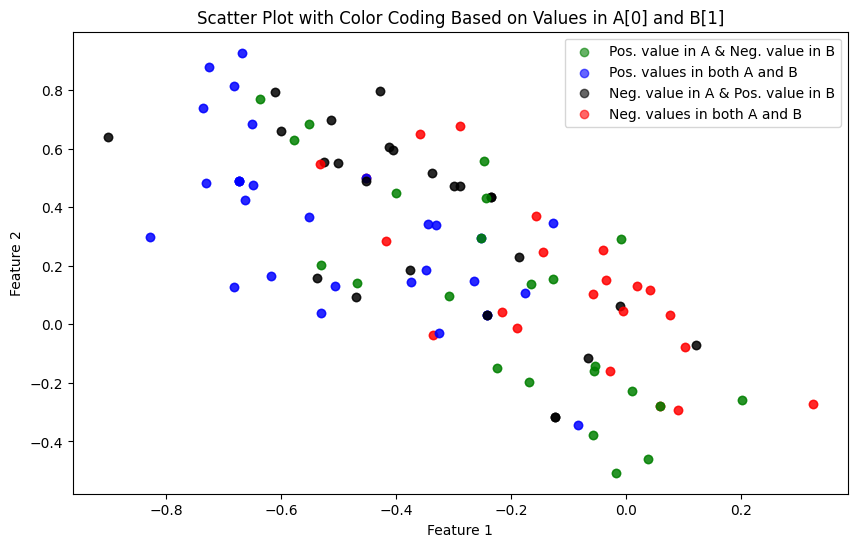

In [101]:
import numpy as np
import matplotlib.pyplot as plt

s,t = generateTrainDataNoiseTop(100, [10,10]) 
s_tensor = torch.Tensor(s)
weighted_output, Q, K, scores, attention, V = modelRNNWithAttention.attention(s_tensor, return_attention=True)

weighted_output_np = [sequence.detach().numpy() for sequence in weighted_output]
# Plot preparation
plt.figure(figsize=(10, 6))

# Updated color labels to reflect the logic more accurately
color_labels = {
    'green': 'Pos. value in A & Neg. value in B',
    'black': 'Neg. value in A & Pos. value in B',
    'blue': 'Pos. values in both A and B',
    'red': 'Neg. values in both A and B'
}

# Iterate through each sequence and its corresponding weighted output
for seq, weighted_output in zip(s, weighted_output_np):
    # Initially, set colors to an empty list to catch errors if none of the conditions below are met
    colors = []

    # Check the specific values at index 0 for Array A and index 1 for Array B
    value_A = seq[0, 0]  # Value at index 0 in Array A
    value_B = seq[1, 1]  # Value at index 1 in Array B

    # Assign colors based on the values in A[0] and B[1]
    if value_A > 0 and value_B < 0:
        colors = ['green', 'green']  # Pos. in A & Neg. in B
    elif value_A < 0 and value_B > 0:
        colors = ['black', 'black']  # Neg. in A & Pos. in B
    elif value_A > 0 and value_B > 0:
        colors = ['blue', 'blue']  # Pos. in both A and B
    elif value_A < 0 and value_B < 0:
        colors = ['red', 'red']  # Neg. in both A and B

    last_two_weighted_output = weighted_output[-2:, :2]
    # Plot the last two weighted output values with determined colors
    for point, color in zip(last_two_weighted_output, colors):
        plt.scatter(point[0], point[1], alpha=0.6, color=color, label=color_labels[color] if color_labels[color] not in plt.gca().get_legend_handles_labels()[1] else "")

plt.title('Scatter Plot for Top focus labels with Color Coding Based on Values in A[0] and B[1]')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [104]:
model_path = "./ModelsWithNoise/model_RNNA_Bottom_min_10_max_10_rep_0.model"
modelRNNWithAttention = torch.load(model_path, map_location=torch.device('cpu'))


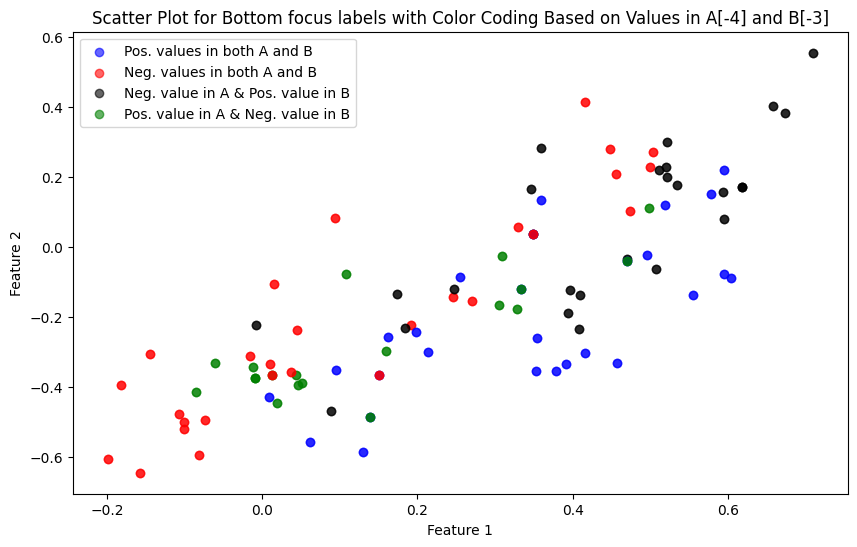

In [105]:
import numpy as np
import matplotlib.pyplot as plt

s,t = generateTrainDataNoiseBottom(100, [10,10]) 
s_tensor = torch.Tensor(s)
weighted_output, Q, K, scores, attention, V = modelRNNWithAttention.attention(s_tensor, return_attention=True)

weighted_output_np = [sequence.detach().numpy() for sequence in weighted_output]
# Plot preparation
plt.figure(figsize=(10, 6))

# Updated color labels to reflect the logic more accurately
color_labels = {
    'green': 'Pos. value in A & Neg. value in B',
    'black': 'Neg. value in A & Pos. value in B',
    'blue': 'Pos. values in both A and B',
    'red': 'Neg. values in both A and B'
}

# Iterate through each sequence and its corresponding weighted output
for seq, weighted_output in zip(s, weighted_output_np):
    # Initially, set colors to an empty list to catch errors if none of the conditions below are met
    colors = []

    # Check the specific values at index -4 for Array A and index -3 for Array B
    value_A = seq[-4, 0]  # Value at index 0 in Array A
    value_B = seq[-3, 1]  # Value at index 1 in Array B

    # Assign colors based on the values in A[0] and B[1]
    if value_A > 0 and value_B < 0:
        colors = ['green', 'green']  # Pos. in A & Neg. in B
    elif value_A < 0 and value_B > 0:
        colors = ['black', 'black']  # Neg. in A & Pos. in B
    elif value_A > 0 and value_B > 0:
        colors = ['blue', 'blue']  # Pos. in both A and B
    elif value_A < 0 and value_B < 0:
        colors = ['red', 'red']  # Neg. in both A and B

    last_two_weighted_output = weighted_output[-2:, :2]
    # Plot the last two weighted output values with determined colors
    for point, color in zip(last_two_weighted_output, colors):
        plt.scatter(point[0], point[1], alpha=0.6, color=color, label=color_labels[color] if color_labels[color] not in plt.gca().get_legend_handles_labels()[1] else "")
plt.title('Scatter Plot for Bottom focus labels with Color Coding Based on Values in A[-4] and B[-3]')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()